In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3 as sql

from utils import *

sns.set()
con = sql.connect("./problems.db")

con.execute(('CREATE TABLE IF NOT EXISTS "problems" ('
  '"Problem" TEXT,'
  '"Algorithm" TEXT,'
  '"N" INTEGER,'
  '"T" INTEGER,'
  '"SA_initial_temperature" REAL,'
  '"SA_cooling_factor" REAL,'
  '"GA_population" REAL,'
  '"GA_mate_number" REAL,'
  '"GA_mutate_number" REAL,'
  '"MIMIC_samples" REAL,'
  '"MIMIC_to_keep" REAL,'
  '"Error" REAL,'
  '"Time" REAL,'
  '"Iteration" INTEGER'
');'))
#con.execute('CREATE INDEX "PB" on "problems" ("Problem");')
#con.execute('CREATE INDEX "ALG" on "problems" ("Algorithm");')
con.enable_load_extension(True)
con.load_extension("./extension-functions")

In [41]:
def generate_sql_z_query(z_name: str):
    return "SELECT DISTINCT "+z_name+" FROM problems"

def generate_sql_xy_query(x_name: str, y_name: str, z_name: str, z_value, filters: dict):
    where_close = z_name+" = '"+str(z_value)+"' "
    for k, lf in filters.items():
        where_close += "AND ("
        first = True
        for v in lf:
            if not first:
                where_close += " OR "
            else:
                first = False
            where_close += str(k)+"='"+str(v)+"'"
        where_close += ") "
    return ("SELECT "+x_name+","
            "min("+y_name+") as min,"
            "max("+y_name+") as max,"
            "median("+y_name+") as median,"
            "avg("+y_name+") as mean "
            "FROM problems "
            "WHERE "+z_name+" = '"+str(z_value)+"' "
            "GROUP BY "+x_name)

def consolidate_data_from_db(con, x_name: str, y_name: str, z_name: str, filters: dict):
    z_value_df = pd.read_sql_query(generate_sql_z_query(z_name), con)
    cd = dict()
    for i in z_value_df.get(z_name):
        query = generate_sql_xy_query(x_name, y_name, z_name, i, filters)
        cd[i] = pd.read_sql_query(query, con)
    return cd

In [3]:
df = pd.read_csv("../Optimization_Results/2018-02-26/problems_results_i.csv",
                 names=("Problem", 
                        "Algorithm", 
                        "SA_initial_temperature",
                        "SA_cooling_factor",
                        "GA_population",
                        "GA_mate_number",
                        "GA_mutate_number",
                        "MIMIC_samples",
                        "MIMIC_to_keep",
                        "Error",
                        "Time",
                        "Iteration")
                )

In [4]:
print(df.columns)

Index(['Problem', 'Algorithm', 'SA_initial_temperature', 'SA_cooling_factor',
       'GA_population', 'GA_mate_number', 'GA_mutate_number', 'MIMIC_samples',
       'MIMIC_to_keep', 'Error', 'Time', 'Iteration'],
      dtype='object')


In [44]:
print(pd.read_sql_query("SELECT DISTINCT Problem from problems", con))

      Problem
0  four_peaks
1    knapsack
2         tsp


In [23]:
ad = pd.read_sql_query("SELECT max(Iteration) from problems", con)
print(ad)

   max(Iteration)
0          600119


cd = consolidate_array_data(df, "Iteration", "Error", "Algorithm", filters=[("Problem", ["four_peaks"])])

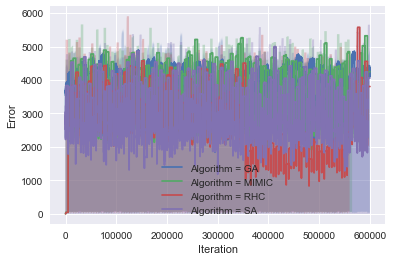

In [43]:
x_arg_name = 'Iteration'
y_arg_name = 'Error'
z_arg_name = 'Algorithm'
filters = {"Problem": ["tsp"]}

cd = consolidate_data_from_db(con, x_arg_name, y_arg_name, z_arg_name, filters)

plt.figure()
for a, d in cd.items():
    plt.plot(d.get(x_arg_name),d.get('median'), 
             label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
    #plt.fill_between(d.get(x_arg_name), d.get('mean') - d.get('std'), d.get('mean') + d.get('std'), alpha=0.3)
    plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
plt.ylabel(y_arg_name.replace('_',' '))
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
#plt.savefig("graphs/boost_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+".png")
plt.show()

In [38]:
print(cd['GA'])

   Iteration   min          max       median         mean
0     114375  1.24  5569.641477  4072.301204  2881.737034


In [40]:
for v in cd.values():
    print(v)

   Iteration   min          max       median         mean
0     114375  1.24  5569.641477  4072.301204  2881.737034
   Iteration  min          max       median         mean
0      30037  1.0  5660.224838  4330.735756  3099.187522
   Iteration  min          max       median        mean
0     120805  0.0  5904.126307  3710.540122  2743.42002
   Iteration  min          max     median        mean
0     596133  0.0  5651.116752  3856.9391  2812.53235
